# Model Fit in Linear Regression - Lab

## Introduction
In this lab, you'll learn how to evaluate your model results, and you'll learn methods to select the appropriate features using stepwise selection.

## Objectives
You will be able to:
* Analyze the results of regression and R-squared and adjusted-R-squared 
* Understand and apply forward and backward predictor selection

## The Boston Housing Data once more

We pre-processed the Boston Housing Data the same way we did before:

- We dropped "ZN" and "NOX" completely
- We categorized "RAD" in 3 bins and "TAX" in 4 bins
- We used min-max-scaling on "B", "CRIM" and "DIS" (and logtransformed all of them first, except "B")
- We used standardization on "AGE", "INDUS", "LSTAT" and "PTRATIO" (and logtransformed all of them first, except for "AGE") 

In [23]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
boston = load_boston()

boston_features = pd.DataFrame(boston.data, columns = boston.feature_names)
boston_features = boston_features.drop(["NOX","ZN"],axis=1)

# first, create bins for based on the values observed. 3 values will result in 2 bins
bins = [0,6,  24]
bins_rad = pd.cut(boston_features['RAD'], bins)
bins_rad = bins_rad.cat.as_unordered()

# first, create bins for based on the values observed. 4 values will result in 3 bins
bins = [0, 270, 360, 712]
bins_tax = pd.cut(boston_features['TAX'], bins)
bins_tax = bins_tax.cat.as_unordered()

bins_rad_codes = bins_rad.cat.codes
bins_tax_codes = bins_tax.cat.codes

tax_dummy = pd.get_dummies(bins_tax_codes, prefix="TAX")
rad_dummy = pd.get_dummies(bins_rad_codes, prefix="RAD")
boston_features = boston_features.drop(["RAD","TAX"], axis=1)
boston_features = pd.concat([boston_features, rad_dummy, tax_dummy], axis=1)

age = boston_features["AGE"]
b = boston_features["B"]
logcrim = np.log(boston_features["CRIM"])
logdis = np.log(boston_features["DIS"])
logindus = np.log(boston_features["INDUS"])
loglstat = np.log(boston_features["LSTAT"])
logptratio = np.log(boston_features["PTRATIO"])

# minmax scaling
boston_features["B"] = (b-min(b))/(max(b)-min(b))
boston_features["CRIM"] = (logcrim-min(logcrim))/(max(logcrim)-min(logcrim))
boston_features["DIS"] = (logdis-min(logdis))/(max(logdis)-min(logdis))

#standardization
boston_features["AGE"] = (age-np.mean(age))/np.sqrt(np.var(age))
boston_features["INDUS"] = (logindus-np.mean(logindus))/np.sqrt(np.var(logindus))
boston_features["LSTAT"] = (loglstat-np.mean(loglstat))/np.sqrt(np.var(loglstat))
boston_features["PTRATIO"] = (logptratio-np.mean(logptratio))/(np.sqrt(np.var(logptratio)))

## Perform stepwise selection

The code for stepwise selection is copied below. Use this code provided on your preprocessed Boston Housing Data.

In [24]:
boston_features.head()

,CRIM,INDUS,CHAS,RM,AGE,DIS,PTRATIO,B,LSTAT,RAD_0,RAD_1,TAX_0,TAX_1,TAX_2
0,0.000000,-1.704344,0.0,6.575,-0.120013,0.542096,-1.443977,1.000000,-1.275260,1,0,0,1,0
1,0.153211,-0.263239,0.0,6.421,0.367166,0.623954,-0.230278,1.000000,-0.263711,1,0,1,0,0
2,0.153134,-0.263239,0.0,7.185,-0.265812,0.623954,-0.230278,0.989737,-1.627858,1,0,1,0,0
3,0.171005,-1.778965,0.0,6.998,-0.809889,0.707895,0.165279,0.994276,-2.153192,1,0,1,0,0
4,0.250315,-1.778965,0.0,7.147,-0.511180,0.707895,0.165279,1.000000,-1.162114,1,0,1,0,0


In [25]:
target = pd.DataFrame(boston.target, columns=["MEDV"])
target.head()

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


In [26]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [27]:
# Your code here
included = stepwise_selection(boston_features, target)
selected = boston_features[included]
selected.head()

Add  LSTAT                          with p-value 9.27989e-122
Add  RM                             with p-value 1.98621e-16
Add  PTRATIO                        with p-value 2.5977e-12
Add  DIS                            with p-value 2.85496e-09
Add  B                              with p-value 2.77572e-06
Add  TAX_0                          with p-value 0.000855799
Add  CHAS                           with p-value 0.00151282
Add  INDUS                          with p-value 0.00588575


,LSTAT,RM,PTRATIO,DIS,B,TAX_0,CHAS,INDUS
0,-1.275260,6.575,-1.443977,0.542096,1.000000,0,0.0,-1.704344
1,-0.263711,6.421,-0.230278,0.623954,1.000000,1,0.0,-0.263239
2,-1.627858,7.185,-0.230278,0.623954,0.989737,1,0.0,-0.263239
3,-2.153192,6.998,0.165279,0.707895,0.994276,1,0.0,-1.778965
4,-1.162114,7.147,0.165279,0.707895,1.000000,1,0.0,-1.778965


### Build the final model again in Statsmodels

In [29]:
from statsmodels.formula.api import ols

outcome = 'MEDV'
pred_sum = '+'.join(selected.columns)
formula = outcome + '~' + pred_sum

model = ols(formula=formula, data=pd.concat([selected, target], axis=1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     215.7
Date:                Sat, 17 Aug 2019   Prob (F-statistic):          2.69e-156
Time:                        12:58:13   Log-Likelihood:                -1461.3
No. Observations:                 506   AIC:                             2941.
Df Residuals:                     497   BIC:                             2979.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8980      2.813      1.742      0.082      -0.628      10.424
LSTAT         -5.5932      0.319    -17.538      0.000      -6.220      -4.967
RM             2.8294      0.386      7.333      0.000       2.071       3.587
PTRATIO       -1.3265      0.226     -5.878      0.000      -1.770      -0.883
DIS           -9.1984      1.333     -6.898      0.000     -11.818      -6.579
B              3.9052      0.931      4.195      0.000       2.076       5.734
TAX_0          1.4418      0.552      2.614      0.009       0.358       2.526
CHAS           2.7988      0.791      3.539      0.000       1.245       4.353
INDUS         -0.9574      0.346     -2.766      0.006      -1.637      -0.277
==============================================================================
Omnibus:                      114.307   Durbin-Watson:                   1.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.579
Skew:                           0.945   Prob(JB):                    1.62e-105
Kurtosis:                       7.395   Cond. No.                         96.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The stepwise procedure mentions that "CHAS" was added with a p-value of 0.00151282, but our statsmodels output returns a p-value of 0.000. Use some of the stepwise procedure logic to find the intuition behind this!

## Use Feature ranking with recursive feature elimination

Use feature ranking to select the 5 most important features

In [31]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 5)
selector = selector.fit(boston_features, target['MEDV'])
selector.support_

array([False, False,  True,  True, False,  True, False,  True,  True,
       False, False, False, False, False])

Fit the linear regression model again using the 5 columns selected

In [38]:
scikit_selection = boston_features.loc[:,selector.support_]

Now, predict $\hat y$ using your model. you can use `.predict()` in scikit-learn

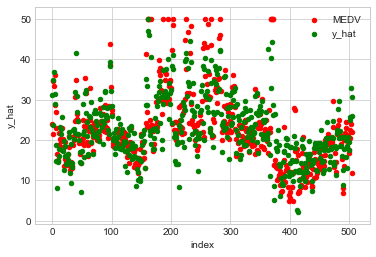

In [71]:
import numpy as np

y = target['MEDV']
linreg = LinearRegression()
linreg.fit(scikit_selection, y)
y_hat = linreg.predict(scikit_selection)
y_hat_df = pd.DataFrame(y_hat, columns=['y_hat'])
df = pd.concat([target,y_hat_df], axis=1)
ax = df.reset_index().plot.scatter(x='index',y='MEDV', color='red', label = 'MEDV')
df.reset_index().plot.scatter(x='index',y='y_hat', color='green', label = 'y_hat', ax=ax)

Now, using the formulas of R-squared and adjusted-R-squared below, and your Python/numpy knowledge, compute them and contrast them with the R-squared and adjusted-R-squared in your statsmodels output using stepwise selection. Which of the two models would you prefer?

$SS_{residual} = \sum (y - \hat{y})^2 $

$SS_{total} = \sum (y - \bar{y})^2 $

$R^2 = 1- \dfrac{SS_{residual}}{SS_{total}}$

$R^2_{adj}= 1-(1-R^2)\dfrac{n-1}{n-p-1}$

In [72]:
# Your code here
SSres = np.sum((y - y_hat)**2)
SStot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (SSres/SStot)
r_squared_adj = 1 - (1-r_squared)*((len(df)-1)/(len(df)-5-1))
# r_squared is 0.742981  
print('r_squared: ', r_squared)
# adjusted_r_squared is 0.740411
print('adj r_squared ', r_squared_adj)

r_squared:  0.7429807743129864
adj r_squared  0.7404105820561162


In [ ]:
# In this case the statsmodels regression, with its 8 features rather than the 5 with scikit learn,
# would be the preferred model because it has both a higher r_squared and adjusted r_squared

## Level up - Optional

- Perform variable selection using forward selection, using this resource: https://planspace.org/20150423-forward_selection_with_statsmodels/. Note that this time features are added based on the adjusted-R-squared!
- Tweak the code in the `stepwise_selection()`-function written above to just perform forward selection based on the p-value.

In [87]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response,
                                           ' + '.join(selected + [candidate]))
            score = ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score <= best_new_score:
            if current_score == best_new_score:
                print('scores equal')
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        elif current_score > best_new_score:
            print('score higher, breaking')
            break
            
        #last_best = best_candidate
        print(remaining)
    formula = "{} ~ {} ".format(response,
                                   ' + '.join(selected))
    model = ols(formula, data).fit()
    return model

In [88]:
model3 = forward_selected(pd.concat([boston_features, target], axis=1), 'MEDV')
model3.summary()

{'B', 'RM', 'AGE', 'TAX_2', 'DIS', 'RAD_1', 'CRIM', 'INDUS', 'PTRATIO', 'TAX_0', 'CHAS', 'TAX_1', 'RAD_0'}
{'B', 'AGE', 'TAX_2', 'DIS', 'RAD_1', 'CRIM', 'INDUS', 'PTRATIO', 'TAX_0', 'CHAS', 'TAX_1', 'RAD_0'}
{'B', 'AGE', 'TAX_2', 'DIS', 'RAD_1', 'CRIM', 'INDUS', 'TAX_0', 'CHAS', 'TAX_1', 'RAD_0'}
{'B', 'AGE', 'TAX_2', 'RAD_1', 'CRIM', 'INDUS', 'TAX_0', 'CHAS', 'TAX_1', 'RAD_0'}
{'AGE', 'TAX_2', 'RAD_1', 'CRIM', 'INDUS', 'TAX_0', 'CHAS', 'TAX_1', 'RAD_0'}
{'AGE', 'TAX_2', 'RAD_1', 'CRIM', 'INDUS', 'CHAS', 'TAX_1', 'RAD_0'}
{'AGE', 'TAX_2', 'RAD_1', 'CRIM', 'INDUS', 'TAX_1', 'RAD_0'}
{'AGE', 'TAX_2', 'RAD_1', 'CRIM', 'TAX_1', 'RAD_0'}
{'AGE', 'TAX_2', 'CRIM', 'TAX_1', 'RAD_0'}
{'AGE', 'CRIM', 'TAX_1', 'RAD_0'}
scores equal
{'AGE', 'CRIM', 'RAD_0'}
scores equal
{'AGE', 'CRIM'}
score higher, breaking


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     174.2
Date:                Sat, 17 Aug 2019   Prob (F-statistic):          4.48e-155
Time:                        14:10:20   Log-Likelihood:                -1458.6
No. Observations:                 506   AIC:                             2939.
Df Residuals:                     495   BIC:                             2986.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6574      1.565      2.337      0.020       0.582       6.732
LSTAT         -5.6444      0.319    -17.707      0.000      -6.271      -5.018
RM             2.6774      0.394      6.800      0.000       1.904       3.451
PTRATIO       -1.4598      0.239     -6.100      0.000      -1.930      -0.990
DIS           -9.7306      1.466     -6.638      0.000     -12.611      -6.850
B              4.0502      0.958      4.227      0.000       2.168       5.933
TAX_0          2.4090      0.676      3.564      0.000       1.081       3.737
CHAS           2.6313      0.793      3.320      0.001       1.074       4.189
INDUS         -0.8935      0.349     -2.561      0.011      -1.579      -0.208
RAD_1          2.2995      0.857      2.682      0.008       0.615       3.984
TAX_2          0.1536      0.589      0.261      0.794      -1.004       1.311
TAX_1          1.0948      0.641      1.709      0.088      -0.164       2.354
RAD_0          1.3578      0.790      1.719      0.086      -0.194       2.910
==============================================================================
Omnibus:                      105.386   Durbin-Watson:                   1.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              428.029
Skew:                           0.877   Prob(JB):                     1.13e-93
Kurtosis:                       7.150   Cond. No.                     6.14e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.76e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
# It appears as though forward selection, leaving out only AGE and CRIM from its feature selection,
# has turned out to be the most accurate model according to r_squared and r_squared_adjusted metrics.

## Summary
Great! You now performed your own feature selection methods!